In [115]:
%pylab inline

import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score

import datetime, time

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [116]:
# Read data
wnv_train = pd.read_csv('../working/train_f.csv', index_col=0)
wnv_test = pd.read_csv('../working/test_f.csv', index_col=0)
#f_names = wnv_train.columns[2:]

In [117]:
# convert list of labels to binary class matrix
labels = wnv_train.WnvPresent.values.astype('int')
yr_train = labels
wnv_train.drop('WnvPresent', axis=1, inplace=True)
f_names = wnv_train.columns

In [118]:
# raw data
#yr_train = wnv_train[:,1].astype(int)
Xr_train =(wnv_train.values).astype('float64')
Xr_test = (wnv_test.values).astype('float64')

# normalize data
scaler = StandardScaler()
scaler.fit(Xr_train)
Xn_train = scaler.transform(Xr_train)
Xn_test = scaler.transform(Xr_test)

X_train, X_test, y_train, y_test = train_test_split(Xn_train, yr_train, test_size=0.5)

In [119]:
# parameters
n_neighbors = 30
n_components = 65
n_estimators = 1000
n_jobs = 3
p_level = 0.3

In [120]:
#clf = KNeighborsClassifier(n_neighbors=n_neighbors)
clf = ExtraTreesClassifier(n_estimators=n_estimators, n_jobs=n_jobs)
#clf.fit(X_train, y_train)
clf.fit(Xn_train, yr_train)

# use the model to predict the labels of the test data
predicted = clf.predict(X_test)
proba = clf.predict_proba(X_test)
expected = y_test

In [121]:
# accuracy
matches = (predicted == expected)
print matches.sum() / float(len(matches))

# f1 score

print classification_report(expected, predicted)

# confusion matrix
print confusion_matrix(expected, predicted)

# auc
print roc_auc_score(expected, proba[:,1])

0.944793451361
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      4963
          1       0.00      0.00      0.00       290

avg / total       0.89      0.94      0.92      5253

[[4963    0]
 [ 290    0]]
0.856381707393


Area under the ROC curve : 0.856382


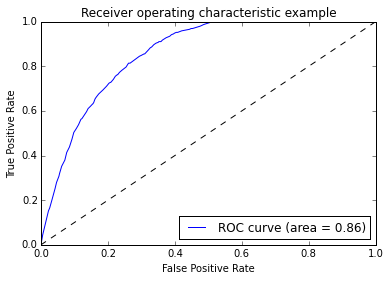

In [122]:
#print np.count_nonzero(predicted == 1)
#print np.count_nonzero(y_test)
#np.max(proba[:,1])
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(expected, proba[:,1])
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc

# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [123]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

#for f in range(len(f_names)):
for f in range(15):
    print("%d. %s (%f)" % (f + 1, f_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. Sunrise (0.069233)
2. Sunset (0.065334)
3. DayOfYear (0.064261)
4. USGS04087440 (0.061231)
5. CULEX PIPIENS (0.054984)
6. CULEX RESTUANS (0.051290)
7. CULEX PIPIENS/RESTUANS (0.038700)
8. MoonPhase (0.030926)
9. USGS05536105 (0.025935)
10. Cool_1 (0.022837)
11. Cool_2 (0.020873)
12. DewPoint_1 (0.020728)
13. DewPoint_2 (0.020500)
14. DayOfWeek (0.020417)
15. Tavg_1 (0.020384)


In [84]:
proba = clf.predict_proba(Xn_test)
print np.max(proba[:,1])

0.46913003663


In [85]:
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')

def write_preds(proba, fname):
    pd.DataFrame({"Id": list(range(1,len(proba)+1)), "WnvPresent": proba}).to_csv(fname, index=False, header=True)

write_preds(proba[:,1], "../working/sklearn_test_" + st + ".csv")